In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_absolute_error

In [3]:
from darts import TimeSeries
from darts.models import AutoARIMA, LightGBMModel

In [4]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set(font_scale=1.25)

In [5]:
##############################################################################################################################################################################################

In [6]:
data = pd.read_csv("train.csv")

In [7]:
train = pd.DataFrame()
train["Unit"] = data["БЕ"]
train["Date"] = data["Дата транзакции"]
train["RUB"] = data["Сумма в RUB"]

In [8]:
train_0 = train[train["Unit"]==0][["Date", "RUB"]]
train_0.set_index(pd.to_datetime(train_0["Date"]), inplace=True)
train_0.drop(["Date"], inplace=True, axis=1)

train_1 = train[train["Unit"]==1][["Date", "RUB"]]
train_1.set_index(pd.to_datetime(train_1["Date"]), inplace=True)
train_1.drop(["Date"], inplace=True, axis=1)

train_2 = train[train["Unit"]==2][["Date", "RUB"]]
train_2.set_index(pd.to_datetime(train_2["Date"]), inplace=True)
train_2.drop(["Date"], inplace=True, axis=1)

train_3 = train[train["Unit"]==3][["Date", "RUB"]]
train_3.set_index(pd.to_datetime(train_3["Date"]), inplace=True)
train_3.drop(["Date"], inplace=True, axis=1)

train_4 = train[train["Unit"]==4][["Date", "RUB"]]
train_4.set_index(pd.to_datetime(train_4["Date"]), inplace=True)
train_4.drop(["Date"], inplace=True, axis=1)

train_5 = train[train["Unit"]==5][["Date", "RUB"]]
train_5.set_index(pd.to_datetime(train_5["Date"]), inplace=True)
train_5.drop(["Date"], inplace=True, axis=1)

train_6 = train[train["Unit"]==6][["Date", "RUB"]]
train_6.set_index(pd.to_datetime(train_6["Date"]), inplace=True)
train_6.drop(["Date"], inplace=True, axis=1)

In [9]:
train_1_1d = train_1.resample('1D').sum()

In [10]:
train_1_1d_reindex = train_1_1d.reset_index(inplace=False)

In [11]:
series_1d = TimeSeries.from_dataframe(train_1_1d_reindex, time_col='Date', value_cols='RUB', freq='1d', fill_missing_dates=True)

In [12]:
train_1d_split, val_1d_split = series_1d.split_before(0.80)

In [18]:
best_result = np.inf
iteration = 0
best_params = {"j": 0, "k": 0, "z": 0}
for j in range(-1, -10, -2):
    for k in range(-1, -90, -3):
        for z in range(-1, -90, -6):
            model1d = LightGBMModel(lags=[j, k, z], output_chunk_length=180)
            model1d.fit(train_1d_split)
            prediction1d = model1d.predict(len(val_1d_split))
            fixed_prediction1d = prediction1d.pd_dataframe()
            current_result = mean_absolute_error(
                val_1d_split.pd_dataframe(), prediction1d.pd_dataframe()
            )
            iteration += 1
            if iteration % 10 == 0:
                print(f"{iteration} итерация")
            if current_result < best_result:
                print(f"New best result is {current_result}")
                best_result = current_result
                best_params["j"] = j
                best_params["k"] = k
                best_params["z"] = z
                print (f"best_params is {best_params.values()}")

New best result is 3374390.965312055
best_params is dict_values([-1, -1, -1])
New best result is 2722171.6548099336
best_params is dict_values([-1, -1, -25])
10 итерация
New best result is 2142166.0232855254
best_params is dict_values([-1, -4, -1])
New best result is 2135826.6965117804
best_params is dict_values([-1, -4, -13])
20 итерация
New best result is 1884669.0735706398
best_params is dict_values([-1, -4, -37])
New best result is 1871300.7645654413
best_params is dict_values([-1, -4, -79])
30 итерация
40 итерация
50 итерация
60 итерация
70 итерация
80 итерация
90 итерация
100 итерация
110 итерация
120 итерация
130 итерация
140 итерация
150 итерация
160 итерация
170 итерация
180 итерация
190 итерация
200 итерация
210 итерация
220 итерация
New best result is 1786271.3430290427
best_params is dict_values([-1, -46, -13])
230 итерация
New best result is 1727233.8657199782
best_params is dict_values([-1, -46, -55])
240 итерация
250 итерация
260 итерация
270 итерация
280 итерация
290 ит

In [13]:
#best_params = {'j': -9, 'k': -25, 'z': -34} (если упорядочить)
#best_params

In [14]:
#fit, predict
model1d = LightGBMModel(lags=[-9, -25, -34], output_chunk_length=180)
model1d.fit(train_1d_split)
prediction1d = model1d.predict(len(val_1d_split))

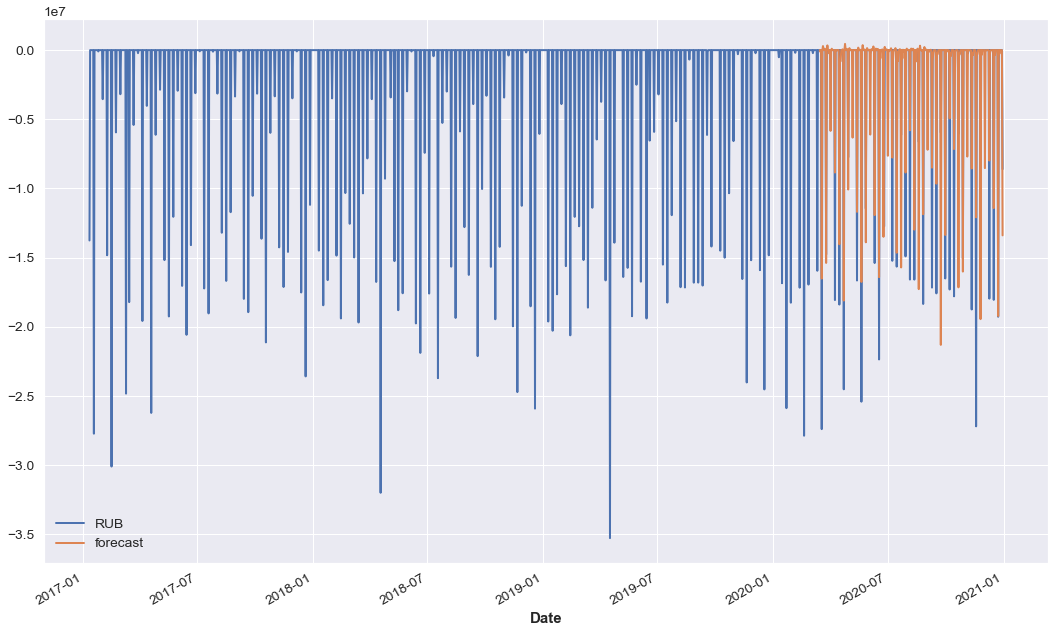

In [15]:
series_1d.plot()
prediction1d.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [16]:
# Предварительный результат.
fixed_prediction1d = prediction1d.pd_dataframe()
mean_absolute_error(val_1d_split.pd_dataframe(), prediction1d.pd_dataframe())

1132436.0330519783

In [17]:
fixed_prediction1d[fixed_prediction1d["RUB"]>0] = 0

In [18]:
# MAE для подправленных данных
mean_absolute_error(val_1d_split.pd_dataframe(), fixed_prediction1d)

1115056.407658611

In [19]:
# AUTOArima

In [20]:
#Делаем шаг по времени 7 дней, все числа суммируем к левому "коренному" вторнику
train_1_7d = train_1.reset_index().groupby(pd.Grouper(key='Date', freq='7D', how='sum', closed='left')).sum()

In [21]:
train_1_7d_reindex = train_1_7d.reset_index(inplace=False)

In [22]:
series_7d = TimeSeries.from_dataframe(train_1_7d_reindex, time_col='Date', value_cols='RUB', freq='7d', fill_missing_dates=True)

In [23]:
train_7d_split, val_7d_split = series_7d.split_before(0.80)

In [24]:
model7d = AutoARIMA()
model7d.fit(train_7d_split)
prediction7d = model7d.predict(len(val_7d_split))

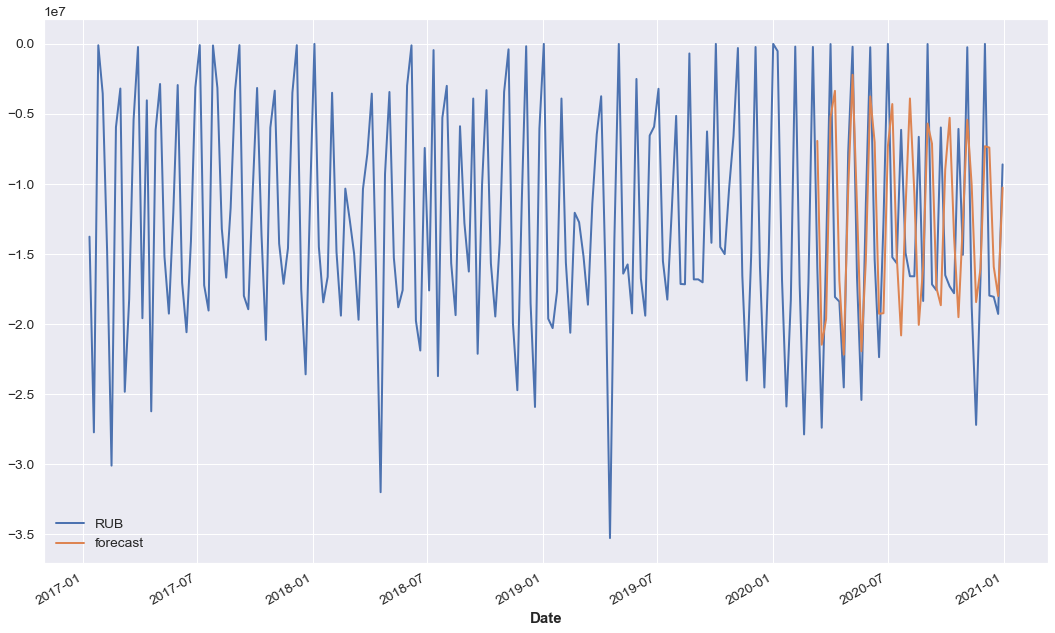

In [25]:
series_7d.plot()
prediction7d.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [26]:
fixed_prediction7d = prediction7d.pd_dataframe()
mean_absolute_error(val_7d_split.pd_dataframe(), prediction7d.pd_dataframe())

6219294.339159989

In [27]:
# Из графика видно, что положительных значений нет
#fixed_prediction7d[fixed_prediction7d["RUB"]>0] = 0

In [28]:
mean_absolute_error(val_7d_split.pd_dataframe(), fixed_prediction7d)

6219294.339159989

In [29]:
# 1115056.407658611
mean_absolute_error(val_1d_split.pd_dataframe(), ((fixed_prediction1d["RUB"] + fixed_prediction7d.resample("1D").sum().loc["2020-03-15":]["RUB"])/1.90).fillna(0))

1026381.7230904928

In [30]:
# График для val и predict

In [31]:
predict_series = ((fixed_prediction1d["RUB"] + fixed_prediction7d.resample("1D").sum().loc["2020-03-15":]["RUB"])/1.90).fillna(0)

In [32]:
val_df = pd.DataFrame()
val_df.index = predict_series.index
val_df["y"] = train_1_1d.loc["2020-03-15":]
val_df["yhat"] = predict_series

<AxesSubplot:xlabel='Date'>

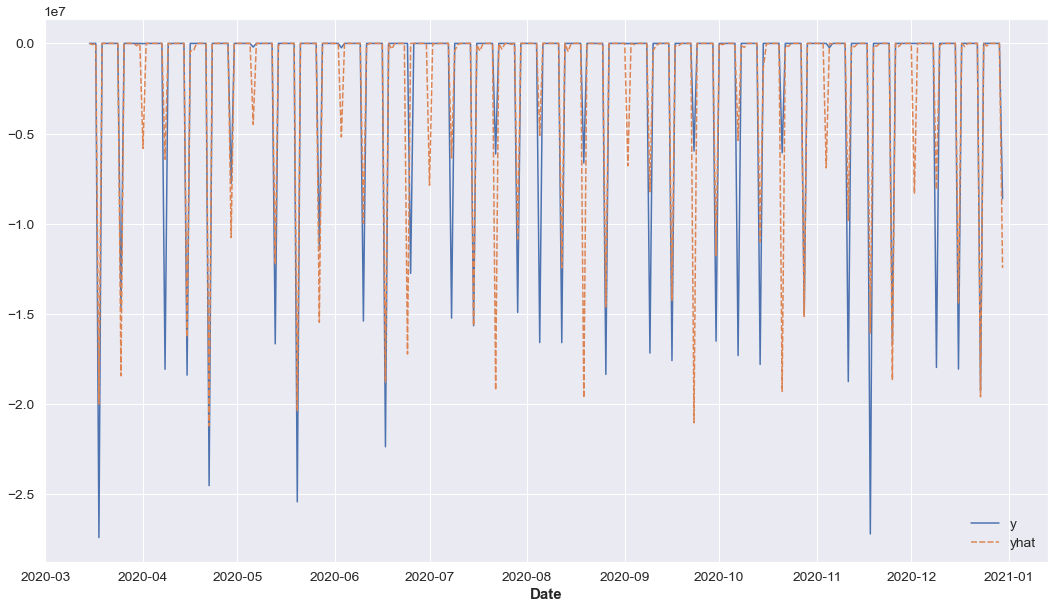

In [33]:
sns.lineplot(data=val_df)

In [34]:
# Делаем refit на полных данных для LightGBM
refit_model1d = LightGBMModel(lags=[-9, -25, -34], output_chunk_length=180)
refit_model1d.fit(series_1d)
refit_prediction1d = refit_model1d.predict(len(pd.date_range(start="2021-01-01", end="2021-06-30", freq="1D"))+1)

In [35]:
refit_prediction1d.pd_dataframe()

component,RUB
Date,
2020-12-31,-2.897554e+06
2021-01-01,-2.632963e+05
2021-01-02,-2.953754e+06
2021-01-03,-1.515578e+05
2021-01-04,-2.946197e+06
...,...
2021-06-26,-3.032754e+06
2021-06-27,-2.076735e+05
2021-06-28,-3.014320e+06


In [36]:
# Предикт с разрешением в 1 день
refit_fixed_prediction1d = refit_prediction1d.pd_dataframe()
refit_fixed_prediction1d[refit_fixed_prediction1d["RUB"]>0] = 0
refit_fixed_prediction1d = refit_fixed_prediction1d.iloc[1:]

In [37]:
# Делаем refit на полных данных для AUTOArima
model7d.fit(series_7d)
refit_prediction7d = model7d.predict(len(pd.date_range(start="2021-01-01", end="2021-06-30", freq="1D"))+1)

In [38]:
refit_fixed_prediction7d = refit_prediction7d.pd_dataframe() # Принимаем форму стандартного датафрейма
refit_fixed_prediction7d[refit_fixed_prediction7d["RUB"]>0] = 0 # Ручная правка положительных значений

In [39]:
#Собираем предикт вместе
train_1_ans = pd.DataFrame() # Вторник
#train_1_ans["Дата транзакции"] = pd.date_range(start="2021-01-05", end="2021-06-29", freq="7D") # legacy version
train_1_ans["Дата транзакции"] = pd.date_range(start="2021-01-01", end="2021-06-30", freq="1D")
# Заполяняем сначала AUTOArima модель
train_1_ans["Сумма в RUB"] = pd.merge(train_1_ans, refit_fixed_prediction7d, how='outer', left_on=train_1_ans["Дата транзакции"], right_on=refit_fixed_prediction7d.index)["RUB"].fillna(0)
train_1_ans["Сумма в RUB"] += refit_fixed_prediction1d["RUB"].values
train_1_ans["Сумма в RUB"] /= 1.90
train_1_ans["Сумма в RUB"] = train_1_ans["Сумма в RUB"].groupby(train_1_ans["Дата транзакции"].dt.month).cumsum().values

train_1_ans["Месяц"] = train_1_ans["Дата транзакции"].dt.month
train_1_ans["БЕ"] = 1


In [40]:
train_1_ans.to_csv("train_1_ans.csv")